In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from xgboost import plot_importance

%config IPCompleter.greedy=True
%matplotlib inline

In [2]:
train = pd.read_csv('train_sample.csv')
train.describe()

,ip,app,device,os,channel,is_attributed
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,91255.879670,12.04788,21.771250,22.818280,268.832460,0.002270
std,69835.553661,14.94150,259.667767,55.943136,129.724248,0.047591
min,9.000000,1.00000,0.000000,0.000000,3.000000,0.000000
25%,40552.000000,3.00000,1.000000,13.000000,145.000000,0.000000
50%,79827.000000,12.00000,1.000000,18.000000,258.000000,0.000000
75%,118252.000000,15.00000,1.000000,19.000000,379.000000,0.000000
max,364757.000000,551.00000,3867.000000,866.000000,498.000000,1.000000


In [3]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [4]:
sum_attributed = train.where(train.is_attributed == 1).is_attributed.count()

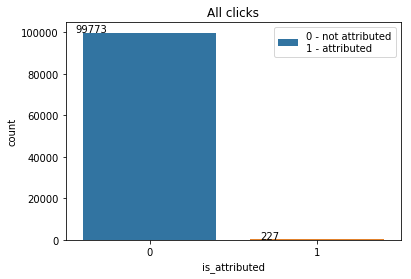

In [5]:
ax = sns.countplot(x='is_attributed', data=train)
ax.set_title("All clicks")
ax.legend(['0 - not attributed\n1 - attributed'])
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.1, p.get_height() * 1.005))

In [6]:
train.ip.value_counts().sort_values(ascending=False).head()

5348     669
5314     616
73487    439
73516    399
53454    280
Name: ip, dtype: int64

In [7]:
train.click_time.min()

'2017-11-06 16:00:00'

In [8]:
train.click_time.max()

'2017-11-09 15:59:51'

In [9]:
train['day'] = pd.DatetimeIndex(train['click_time']).day
train['hour'] = pd.DatetimeIndex(train['click_time']).hour
train['minute'] = pd.DatetimeIndex(train['click_time']).minute
train['sec'] = pd.DatetimeIndex(train['click_time']).second


train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,sec
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0,7,9,30,38
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0,7,13,40,27
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0,7,18,5,24
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0,7,4,58,8
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0,9,9,0,9


In [10]:
train[train['ip'] == 5348].groupby(['day', 'hour']).count()

ip  app  device  os  channel  click_time  attributed_time  \
day hour                                                              
6   17     2    2       2   2        2           2                0   
    18     2    2       2   2        2           2                0   
    19     2    2       2   2        2           2                0   
    20     1    1       1   1        1           1                0   
    21     2    2       2   2        2           2                0   
    22     7    7       7   7        7           7                0   
    23     5    5       5   5        5           5                0   
7   0      5    5       5   5        5           5                0   
    1      3    3       3   3        3           3                0   
    2      2    2       2   2        2           2                0   
    3      8    8       8   8        8           8                0   
    4     14   14      14  14       14          14                0   
    5     10   10      10  10       10          10                0   
    6      8    8       8   8        8           8                0   
    7      7    7       7   7        7           7                0   
    8      9    9       9   9        9           9                0   
    9     13   13      13  13       13          13                0   
    10    17   17      17  17       17          17                0   
    11    23   23      23  23       23          23                0   
    12    27   27      27  27       27          27                0   
    13    28   28      28  28       28          28                0   
    14    23   23      23  23       23          23                1   
    15    10   10      10  10       10          10                0   
    16    14   14      14  14       14          14                0   
    17     6    6       6   6        6           6                0   
    18     5    5       5   5        5           5                0   
    19     5    5       5   5        5           5                0   
    20     2    2       2   2        2           2                0   
    21     1    1       1   1        1           1                0   
    22    12   12      12  12       12          12                0   
...       ..  ...     ...  ..      ...         ...              ...   
8   8      4    4       4   4        4           4                0   
    9      6    6       6   6        6           6                0   
    10    17   17      17  17       17          17                0   
    11    14   14      14  14       14          14                0   
    12    15   15      15  15       15          15                0   
    13    13   13      13  13       13          13                0   
    14    18   18      18  18       18          18                0   
    15    12   12      12  12       12          12                0   
    16    10   10      10  10       10          10                0   
    17     1    1       1   1        1           1                0   
    18     3    3       3   3        3           3                0   
    21     2    2       2   2        2           2                0   
    22     4    4       4   4        4           4                0   
    23     5    5       5   5        5           5                0   
9   0      7    7       7   7        7           7                0   
    1      7    7       7   7        7           7                0   
    2      4    4       4   4        4           4                0   
    3     11   11      11  11       11          11                0   
    4     14   14      14  14       14          14                0   
    5     13   13      13  13       13          13                0   
    6     13   13      13  13       13          13                0   
    7     10   10      10  10       10          10                0   
    8      7    7       7   7        7           7                0   
    9      8    8       8   8     

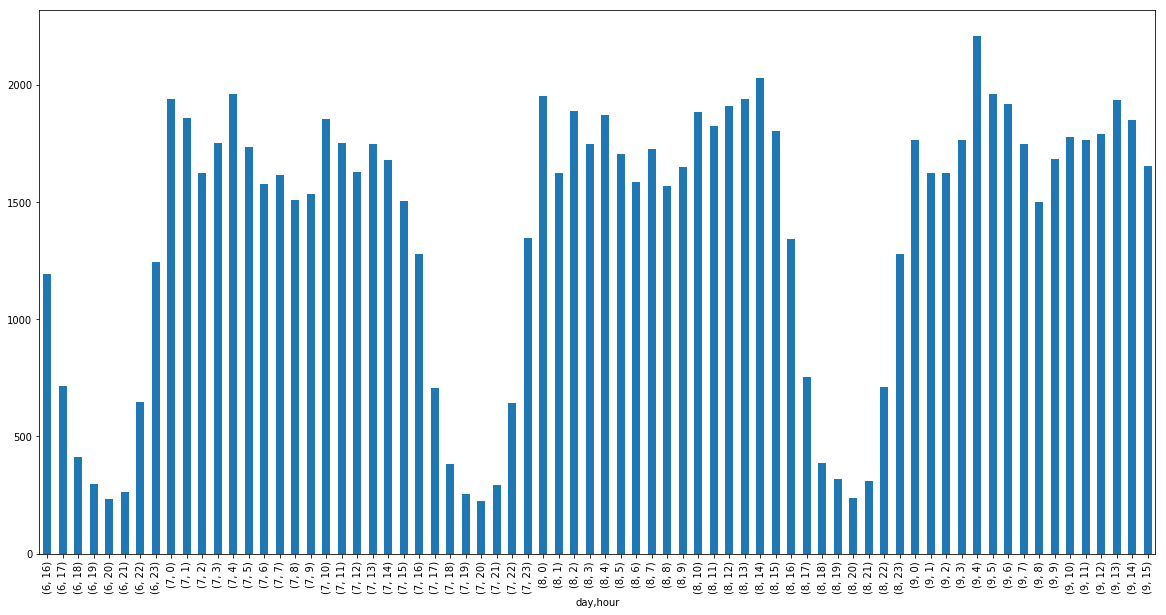

In [11]:
train.sort_values('click_time').groupby(['day', 'hour']).size().plot.bar(figsize=(20,10))

In [12]:
train = train.drop(['click_time'], axis=1)
train = train.drop(['attributed_time'], axis=1)

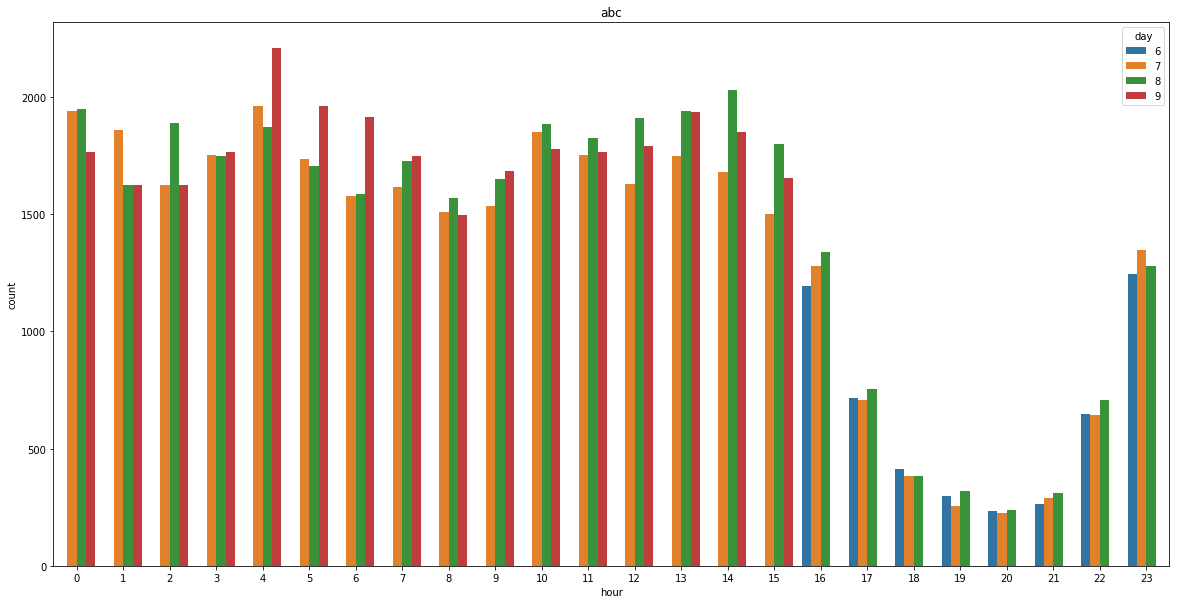

In [13]:
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.countplot(x="hour", hue="day", data=train, ax=ax)
ax.set(xlabel='hour', ylabel='count')
ax.set_title('abc')
plt.show()

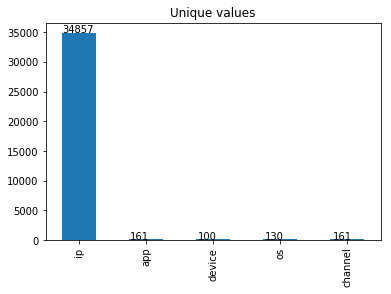

In [14]:
counted_values_all = train.nunique()
counted_values = counted_values_all.drop(['is_attributed', 'day', 'hour', 'minute', 'sec'])
ax = counted_values.plot.bar(title='Unique values')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01, p.get_height() * 1.005))

Ip's that have only not-attributed clicks:

In [15]:
grouped = train['is_attributed'].groupby(train['ip'])
sum = grouped.sum()
never_attributed_ip = sum[sum == 0]

In [16]:
never_attributed_ip.size

34634

Ip's that have only attributed clicks:

In [17]:
attributed_at_least_once_ip = sum.drop(never_attributed_ip.index)
attributed_at_least_once_ip.size

223

## Working on ID's that have 100% not attributed clicks

Number of clicks that non-attributed-ids made:

In [18]:
never_attributed_ip_counted_clicks = pd.Series(index=never_attributed_ip.index)
counted_clicks = train[train['ip'].isin(never_attributed_ip.index)].groupby(train['ip']).count()
never_attributed_ip_counted_clicks = counted_clicks.device
never_attributed_ip_counted_clicks = never_attributed_ip_counted_clicks.sort_values(ascending=False)

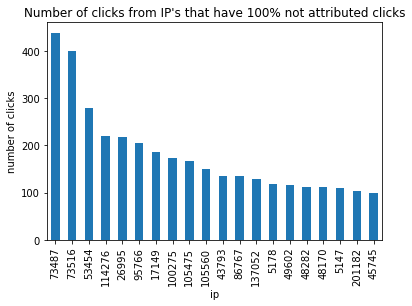

In [19]:
ax = never_attributed_ip_counted_clicks.head(20).plot.bar()
ax.set_title('Number of clicks from IP\'s that have 100% not attributed clicks')
ax.set_ylabel('number of clicks')
plt.show()

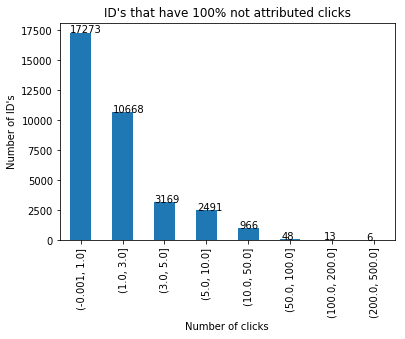

In [20]:
out = pd.cut(never_attributed_ip_counted_clicks, bins=[0, 1, 3, 5, 10, 50, 100, 200, 500], include_lowest=True)
ax = out.value_counts().plot.bar()
ax.set_title('ID\'s that have 100% not attributed clicks')
ax.set_ylabel('Number of ID\'s')
ax.set_xlabel('Number of clicks')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01, p.get_height() * 1.001))

In [21]:
not_attr_clicks = train.where(train.ip.isin(never_attributed_ip.index).copy())

ip_groups = pd.DataFrame(index=out.index, data=out).reset_index()
ip_groups = ip_groups.rename(columns={'device':'group'})    

not_attr_clicks = pd.merge(not_attr_clicks, ip_groups, on='ip')

## Comparing attr_clicks and not_attr_clicks:

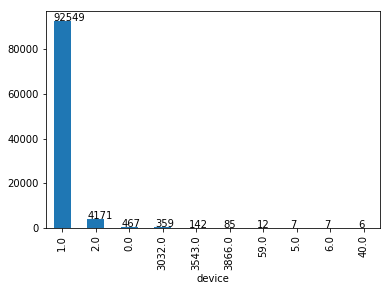

In [22]:
ax = not_attr_clicks.groupby('device').ip.count().sort_values(ascending=False).head(10).plot.bar()
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01, p.get_height() * 1.001))

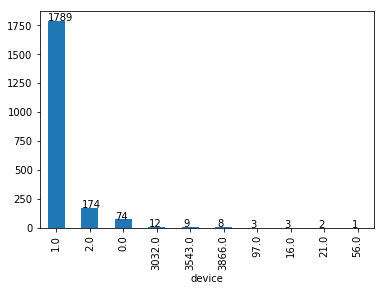

In [23]:
attr_at_least_once_clicks = train.where(train.ip.isin(attributed_at_least_once_ip.index).copy())

nan_ip = attr_at_least_once_clicks[attr_at_least_once_clicks.ip.isna()]
attr_at_least_once_clicks = attr_at_least_once_clicks.dropna(how='all')
ax = attr_at_least_once_clicks.groupby('device').ip.count().sort_values(ascending=False).head(10).plot.bar()
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01, p.get_height() * 1.001))

## Comparing groups of not attributed clicks:

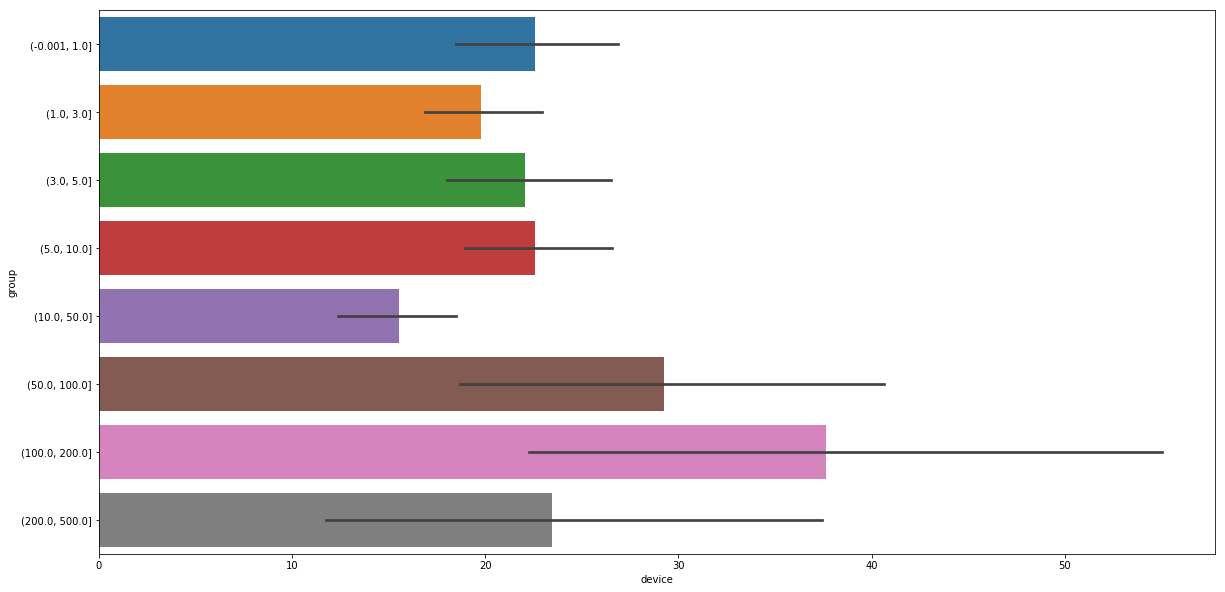

In [24]:
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.barplot('device', 'group', data=not_attr_clicks)

## XGBoost

In [25]:
# param = {'max_depth': 2, 'eta': 1, 'silent': 1, 'objective': 'binary:logistic'}
# param['nthread'] = 4
# param['eval_metric'] = 'auc'

In [26]:
train_data = train[['ip', 'app', 'device', 'os', 'channel', 'day', 'hour', 'minute', 'sec']]

In [36]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train['is_attributed'])

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

/home/ngiersz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [46]:
# X_train, X_train_label = X_train.iloc[:,:-1],X_train.iloc[:,-1]
# X_test, X_test_label = X_test.iloc[:,:-1],X_test.iloc[:,-1]


In [29]:
params = {'eta': 0.3,
          'tree_method': "hist",
          'grow_policy': "lossguide",
          'max_leaves': 1400,  
          'max_depth': 0, 
          'subsample': 0.9, 
          'colsample_bytree': 0.7, 
          'colsample_bylevel':0.7,
          'min_child_weight':0,
          'alpha':4,
          'objective': 'binary:logistic', 
          'scale_pos_weight':9,
          'eval_metric': 'auc', 
          'nthread':8,
          'random_state': 99, 
          'silent': True}
# params = None
params

{'eta': 0.3,
 'tree_method': 'hist',
 'grow_policy': 'lossguide',
 'max_leaves': 1400,
 'max_depth': 0,
 'subsample': 0.9,
 'colsample_bytree': 0.7,
 'colsample_bylevel': 0.7,
 'min_child_weight': 0,
 'alpha': 4,
 'objective': 'binary:logistic',
 'scale_pos_weight': 9,
 'eval_metric': 'auc',
 'nthread': 8,
 'random_state': 99,
 'silent': True}

In [30]:
params_list = [
    {
        'objective': 'binary:logistic', 
       'colsample_bytree': 0.3, 
       'learning_rate': 0.1,
       'max_depth': 30, 
       'alpha': 10, 
       'n_estimators': 150, 
       'early_stopping_rounds': 5
    },
    {
        'objective': 'binary:logistic', 
       'colsample_bytree': 0.3, 
       'learning_rate': 0.1,
       'max_depth': 50, 
       'alpha': 10, 
       'n_estimators': 500, 
       'early_stopping_rounds': 5
    },
    {
        'objective': 'binary:logistic', 
       'colsample_bytree': 0.3, 
       'learning_rate': 0.1,
       'max_depth': 30, 
       'alpha': 10, 
       'n_estimators': 100, 
       'early_stopping_rounds': 5
    }
    
]

In [31]:
# xg_reg = xgb.XGBClassifier(objective ='binary:logistic', 
#                            colsample_bytree = 0.3, 
#                            learning_rate = 0.1,
#                            max_depth = 30, 
#                            alpha = 10, 
#                            n_estimators = 500, 
#                            early_stopping_rounds=5)

In [41]:
watchlist = [(dtrain, 'train'), (dtest, 'valid')]
model = xgb.train(params, dtrain, 200, watchlist, maximize=True, early_stopping_rounds = 25, verbose_eval=5)


[0]	train-auc:0.815403	valid-auc:0.805235
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 25 rounds.
[5]	train-auc:0.942391	valid-auc:0.919506
[10]	train-auc:0.990256	valid-auc:0.940093
[15]	train-auc:0.999592	valid-auc:0.938285
[20]	train-auc:0.999925	valid-auc:0.937733
[25]	train-auc:0.999975	valid-auc:0.935143
[30]	train-auc:0.999994	valid-auc:0.929037
[35]	train-auc:0.999995	valid-auc:0.926655
[40]	train-auc:0.999999	valid-auc:0.922493
Stopping. Best iteration:
[17]	train-auc:0.999812	valid-auc:0.944612



In [42]:
# xg_reg.fit(X_train, y_train)

preds = model.predict(dtest)

In [43]:
roc_auc = roc_auc_score(y_test, preds)
print("ROC AUC: %f" % (roc_auc))

ROC AUC: 0.925247


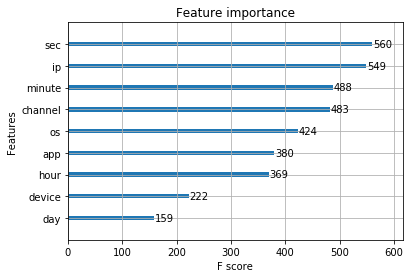

In [44]:
plot_importance(model)
